In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
class Music(object):
    def __init__(self):
        self.scale = [
            'C','C#','D','D#',
            'E','F','F#','G',
            'G#','A','A#','B'
        ]
        # ----------------------------
        # Sets of semitone steps for 
        #
        ## scales 
        ### pentatonic
        self.pentatonic_major = [0,2,4,7,9]
        self.pentatonic_minor = [0,3,5,7,10]
        ## diatonic
        self.diatonic_major = [0,]
        ### minor
        self.natural_minor = [0,2,3,5,7,8,10]
        ### harmonic minor
        self.phrygian_dominant = [0,1,4,5,7,8,10]
        
        ## chords
        self.triad_major = [0,4,7]
        self.triad_minor = [0,3,7]
        ### add7
        self.seventh_dominant = [0,4,7,10]
        self.seventh_major = [0,4,7,11]
        ### hendrix: dominant 7♯9
        self.seventh_sharp_ninth_dominant = [0,4,7,10,15]
        ###     r, 3, (5), ♭7, (9), ♯11, (13)
        self.lydian_major = [0,4,7,10,18]#[0,4,7,10,14,18,21]
        
    def get_root_index(self,root='C'):
        # returns the index of the root note
        ind=0
        for i,e in enumerate(self.scale):
            if root==e: ind=i
        return ind
    
    def wraparound(self,i):
        # rockaround the chromatic scale
        if i >= len(self.scale):
            i = i % len(self.scale)
        return i

    # -----------------------------------------
    def return_notes(self,
                     root='C',
                     scale_type='triad',
                     kind='major'):
        '''
        root = Root note. Default: C
        scale_type = return notes for chords or scales. Default: triad chords
        kind = major, minor, etc.. Default: major
        
        Returns a list of notes. 
        '''
        ind = self.get_root_index(root)
        # semitone steps in integer
        steps = getattr(self,scale_type+'_'+kind)
        notes=[]
        for x in steps:
            notes.append(self.scale[self.wraparound(ind+x)])
        return notes

class Guitar(object):
    def __init__(self,Music):
        self.tuning=['E','A','D','G','B','E']
        self.steps=21
        # init the figure
        self.f, self.ax = plt.subplots(1,1,figsize=(18,2))
        
        # fretboard is a dataframe of each note
        # string int | note | fret int  
        self.fretboard= pd.DataFrame()
        for string_int,string in enumerate(self.tuning):
            notes=[]
            root_ind = Music.get_root_index(string)
            for semitone in range(0,self.steps+1):
                notes.append(Music.scale[Music.wraparound(root_ind+semitone)])
            tmp = pd.DataFrame(list(zip(notes, [x for x in range(0,self.steps+1)])),columns =['notes', 'fret'])
            tmp['string']=string_int
            self.fretboard = pd.concat([self.fretboard,tmp])
                                             
    def draw_neck(self):
        """
        draw the basic neck
        """
        # draw strings
        for y in range(0,len(self.tuning)):
            self.ax.hlines(xmin=0,xmax=self.steps,y=y,color='#6E6E6E',linewidth=0.66)
        
        # draw frets
        tix=[]
        ymin,ymax=0-0.25,len(self.tuning)
        for x in range(0,self.steps+1):
            self.ax.vlines(ymin=ymin,ymax=ymax-0.7,x=x,color='black')
            if x>=3 or x>=15:
                # draw dots
                if x % 2 == 1 and (x<11 or (x > 13 and x<20)):
                    self.ax.scatter(x=(x-1)+.5,y=(ymax-0.7)/2,color='black',s=30)
                    tix.append((x-1)+.5)
                if x==12:
                    tix.append((x-1)+.5)
                    self.ax.scatter(x=(x-1)+.5,y=(ymax-0.7)/4,color='black',s=30)
                    self.ax.scatter(x=(x-1)+.5,y=(ymax-0.7)-((ymax-0.7)/4),color='black',s=30)
            
        self.ax.set_facecolor('#dec49d')
        self.ax.set_xlim(0-0.2,self.steps)
        self.ax.set_ylim(ymin,ymax)
        self.ax.set_xticks(tix)
        self.ax.set_xticklabels(['III','V','VII','IX','XII','XV','XVII','XIX'],fontsize=13,weight='bold')
        self.ax.set_yticks([x for x in range(0,len(self.tuning))])
        self.ax.set_yticklabels(self.tuning,fontsize=13,weight='bold')

        sns.despine(ax=self.ax)
        
        self.f.tight_layout()
    
    def fret_notes(self,notes,color_notes=False):
        """
        given a set of notes, return a list
        of lists containg the fret positions
        """
        self.draw_neck()
        fret = self.fretboard.loc[self.fretboard['notes'].isin(notes)]
        fret = self.fretboard.loc[self.fretboard['notes'].isin(notes)]
        pal = ['mediumspringgreen','gainsboro']
        if color_notes != False: pal = color_notes
        if color_notes == True: pal = 'Greens_r'
        if color_notes == False:
            _pal=[0]
            for i in range(1,len(notes)): _pal.append(1)
            fret['color']=fret['notes'].replace(dict(zip(notes,_pal)))
        else:
            _pal=[]
            for i in range(0,len(notes)): _pal.append(i)
            fret['color']=fret['notes'].replace(dict(zip(notes,_pal)))            
            
        # offset the notes
        fret['fret']=[x-0.75 if x else 0-0.1 for x in fret['fret']]
        
        sns.scatterplot(
            x='fret',
            y='string',
            hue='color',
            palette=pal,
            ax=self.ax,
            s=150,
            edgecolor='black',
            data=fret,
            legend=None,
            alpha=1.,
            zorder=10,
            linewidth=1.3,
        )
        
        self.ax.set_xlabel('')
        self.ax.set_ylabel('')
        self.ax.set_ylim(0-0.4,len(self.tuning)-0.5)
        #self.ax.legend(ncol=len(notes))
        self.f.tight_layout()
    
    def smash_guitar(self):
        "clears the plot"
        self.f.clf()

In [3]:
Music().return_notes('G','seventh_sharp_ninth','dominant')
# C, E, G, B♭, (D), F♯, (A)

['G', 'B', 'D', 'F', 'A#']

['D', 'F#', 'A', 'C']


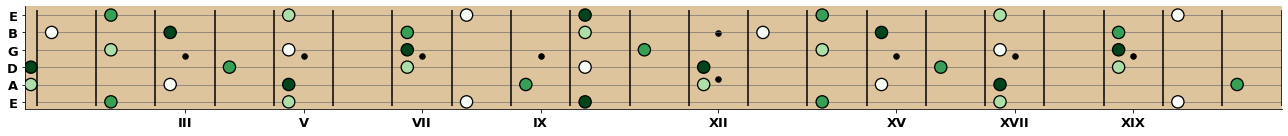

In [4]:
M = Music()
s = M.return_notes('D','seventh','dominant')
print(s)
G = Guitar(M)
G.fret_notes(s,color_notes=True)
#G.f.savefig("arpeggio.svg")